In [1]:
import os
import numpy as np
from pandas import read_csv

## Section 1: Model Diagnostics

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load Stan summary.
df = read_csv(os.path.join('stan_results','rstd_summary.tsv'), sep='\t', index_col='name')
df = df.T.filter(regex='theta').T

## Count problematic parameters.
m = (df.R_hat >= 1.1).sum()
n = df.R_hat.size
print(f'Number of parameters: %s/%s (%0.3f%%)' %(m,n,m/n))

## Identify problematic participants.
sub = df.T.filter(regex='theta').T.query('R_hat > 1')
sub = np.unique([int(s.replace(']','').split(',')[-1]) - 1 for s in sub.index])
m = sub.size; n = df.T.filter(regex='theta_pr\[1').shape[-1]
print('Number of subjects: %s/%s (%0.3f%%)' %(m,n,m/n))

Number of parameters: 28/1158 (0.024%)
Number of subjects: 11/386 (0.028%)


## Section 2: Posterior Predictive Check

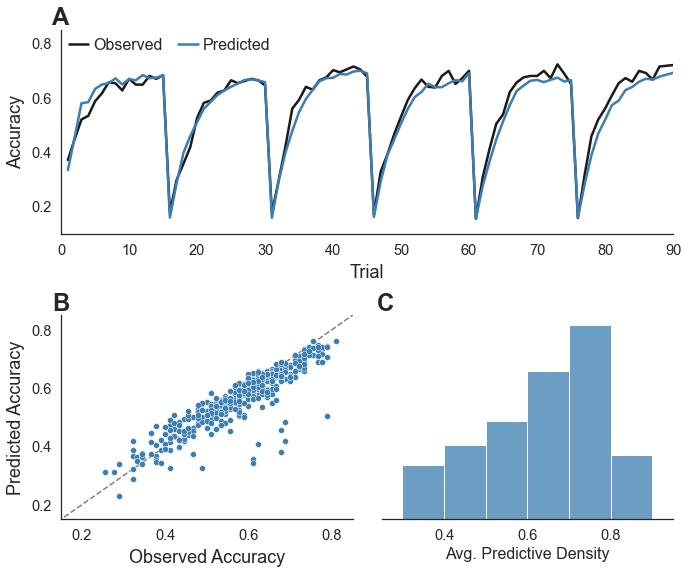

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(10,8))

## Load data.
data = read_csv(os.path.join('data', 'data.csv'))

## Restrict participants.
metrics = read_csv(os.path.join('data', 'metrics.csv'))
data = data[data.subject.isin(metrics.subject)].reset_index(drop=True)

## Load posterior predictive check.
ppc = read_csv('stan_results/rstd_ppc.tsv.gz', sep='\t', compression='gzip')

## Drop participants with ill-fitting models.
drop_ix = metrics.subject.sort_values().values[sub]
data = data[~data.subject.isin(drop_ix)]
ppc = ppc[~ppc.subject.isin(drop_ix)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel A.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Plot predicted accuracy across trials.
ax = plt.subplot2grid((2,2),(0,0),colspan=2)
for df, label, color in zip([data,ppc], ['Observed','Predicted'], ['k','#3b7eb1']):
    ax.plot(df.groupby('trial').accuracy.mean(), color=color, lw=2.5, label=label)
    
## Add detail.
ax.set(xlim=(0,90), ylim=(0.1,0.85))
ax.set_xlabel('Trial', fontsize=18, labelpad=6)
ax.set_ylabel('Accuracy', fontsize=18, labelpad=6)
ax.legend(loc=2, frameon=False, ncol=2, fontsize=16, borderpad=0, handlelength=1.2, 
          handletextpad=0.3, columnspacing=1)
sns.despine(ax=ax)

## Add label.
ax.annotate('A', (0,0), (-0.015,1), xycoords='axes fraction', ha='left', va='bottom', 
            fontsize=24, fontweight='bold')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel B.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Plot predicted accuracy across participants.
ax = plt.subplot2grid((2,2),(1,0))
sns.scatterplot(x=data.groupby('subject').accuracy.mean(), 
                y=ppc.groupby('subject').accuracy.mean(), 
                color='#3b7eb1', ax=ax)
ax.plot([0,1],[0,1],linestyle='--',color='0.5',zorder=-1)

## Add detail.
ax.set(xlim=(0.15,0.85),ylim=(0.15,0.85))
ax.set_xlabel('Observed Accuracy', fontsize=18, labelpad=6)
ax.set_ylabel('Predicted Accuracy', fontsize=18, labelpad=6)
sns.despine(ax=ax)

## Add label.
ax.annotate('B', (0,0), (-0.03,1), xycoords='axes fraction', ha='left', va='bottom', 
            fontsize=24, fontweight='bold')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel C.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Plot distribution of average predictive density per subject.
ax = plt.subplot2grid((2,2),(1,1))
sns.histplot(ppc.groupby('subject').choice.mean(), color='#3b7eb1', bins=np.arange(0.2,1.1,0.1))

## Add detail.
ax.set(xlim=(0.25, 0.95), xticks=[0.4,0.6,0.8], yticks=[], ylabel='')
ax.set_xlabel('Avg. Predictive Density')
sns.despine(left=True, ax=ax)

## Add label.
ax.annotate('C', (0,0), (-0.015,1), xycoords='axes fraction', ha='left', va='bottom', 
            fontsize=24, fontweight='bold')

## Save figure.
plt.subplots_adjust(left=0.10, right=0.95, top=0.95, bottom=0.1, hspace=0.4, wspace=0.1)
plt.savefig(os.path.join('figures','supp_05.png'), dpi=180, transparent=True)